In [1]:
from imports import *
from read_data import *
from bgls import *
from periodogram import compute_LSperiodogram, bootstrap_FAP
import matplotlib.gridspec as gridspec
%matplotlib inline

## get RV and transit data

In [9]:
# get data
fullRVs = True
bjd, rv, erv, program, bjdshort, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = read_HARPS(fullRVs)

# remove bad points known from loocv
badRVs = np.array([63])
g = np.delete(np.arange(bjd.size), badRVs)
bjd, rv, erv, program, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = \
bjd[g],rv[g],erv[g],program[g],Halpha[g],eHalpha[g],Hbeta[g],eHbeta[g],Hgamma[g],eHgamma[g],NaD[g],eNaD[g],Sindex[g],eSindex[g]
#bjd, rv, erv, program = bjd[g],rv[g],erv[g], program[g]
bad = np.array([48])
g = np.delete(np.arange(bjdshort.size), bad)
bjdshort, fwhm, bis = bjdshort[g], fwhm[g], bis[g]
Binds = program == 'Bonfils'
Jinds = program == 'Jenkins'
print bjd.size

-5678.38
161


Text(0,0.5,u'raw RV [m/s]')

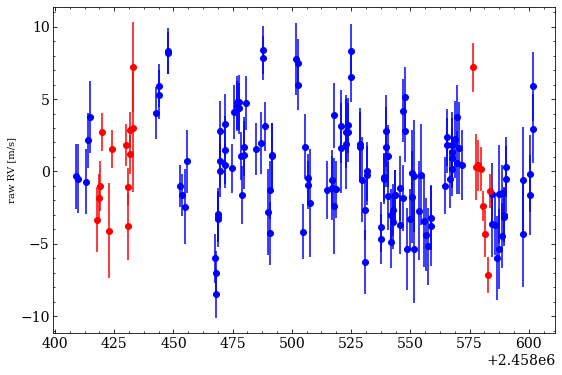

In [3]:
# plot RV time-series
plt.figure(figsize=(9,6))
plt.errorbar(bjd[Binds], rv[Binds], erv[Binds], fmt='bo', capsize=0, label='HARPS-Bon')
plt.errorbar(bjd[Jinds], rv[Jinds], erv[Jinds], fmt='ro', capsize=0, label='HARPS-Jen')
plt.ylabel('raw RV [m/s]')

## plot periodograms

In [4]:
def do_bootstrap(x, y, ey, plims, N):
    pwrs,faps,_,_ = bootstrap_FAP(x, y, ey, plims=plims, N=int(N), quiet=True)
    return faps, pwrs


def scale_err(rv, erv, arr):
    '''Derive uncertainties for an input timeseries based on the fractional RV uncertainties for use in periodogram
    calulations.'''
    return arr * erv / rv

In [16]:
# compute bootstrap results once
Hlen = bjd.max()-bjd.min()

save_bootstraps = 1
if save_bootstraps:
    
    # HARPS
    xH = [bjd, bjd, bjdshort, bjdshort, bjd, bjd, bjd, bjd, bjd]
    yH = [rv, bjd, fwhm, bis, \
          Halpha, Hbeta, Hgamma, NaD, Sindex]
    match = np.in1d(bjd, bjdshort)
    eyH = [erv, np.ones(bjd.size), scale_err(rv[match],erv[match],fwhm), scale_err(rv[match],erv[match],bis), \
           eHalpha, eHbeta, eHgamma, eNaD, eSindex]
    labelsH = ['RV','WF','FWHM','BIS','Halpha','Hbeta','Hgamma','NaD','Sindex']
    for i in range(len(yH)):
        print i/float(len(yH))
        faps, pwrs = do_bootstrap(xH[i], yH[i], eyH[i], (.5,Hlen), 1e4)
        np.save('output_data/FAPS_full_%s'%labelsH[i], np.array([faps,pwrs]).T)

0.222222222222
Computing FAPs from bootstrapping...
0.333333333333
Computing FAPs from bootstrapping...
0.444444444444
Computing FAPs from bootstrapping...
0.555555555556
Computing FAPs from bootstrapping...
0.666666666667
Computing FAPs from bootstrapping...
0.777777777778
Computing FAPs from bootstrapping...
0.888888888889
Computing FAPs from bootstrapping...


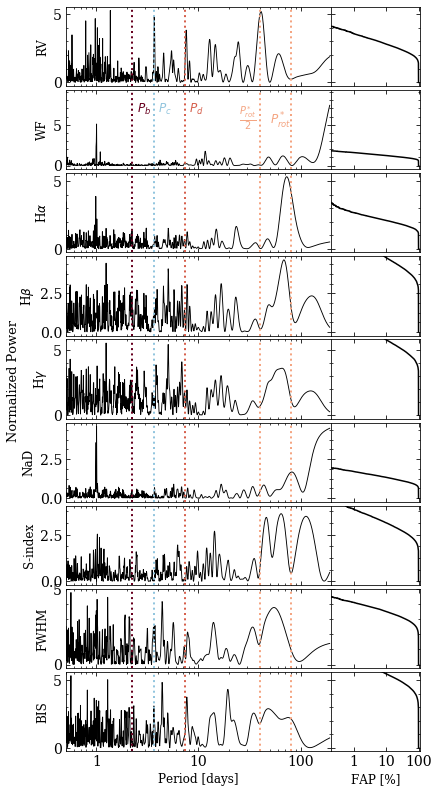

In [18]:
# plot periodograms
colH = 'k'
fig = plt.figure(figsize=(6,11))
gs = gridspec.GridSpec(9,4)

# RVs
ax01 = plt.subplot(gs[0,:-1])
per,pwr,_ = compute_LSperiodogram(bjd, rv, erv, plims=(.5,Hlen))
normH = pwr.std()
ax01.plot(per, pwr/normH, '-', c=colH, lw=.9)
# RV faps
ax02 = plt.subplot(gs[0,-1])
faps, pwrs = np.load('output_data/FAPS_full_RV.npy').T
ax02.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax02.set_xscale('log'), ax01.set_xscale('log')
ax02.set_xlim((2e-3,1.1)), ax01.set_xlim((.5,200))
ax02.set_ylim(ax01.get_ylim()), ax02.set_yticklabels('')
ax02.set_xticks(np.logspace(-2,0,3))
ax01.set_ylabel('RV', fontsize=12)
ax02.set_xticklabels(''), ax01.set_xticklabels('')

# WF
ax11 = plt.subplot(gs[1,:-1])
per,pwr,_ = compute_LSperiodogram(bjd, bjd, np.ones(bjd.size), plims=(.5,Hlen))
normH = pwr.std()
ax11.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax12 = plt.subplot(gs[1,-1])
faps, pwrs = np.load('output_data/FAPS_full_WF.npy').T
ax12.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax12.set_xscale('log'), ax11.set_xscale('log')
ax12.set_xlim((2e-3,1.1)), ax11.set_xlim((.5,200))
ax12.set_ylim(ax11.get_ylim()), ax12.set_yticklabels('')
ax12.set_xticks(np.logspace(-2,0,3))
ax11.set_ylabel('WF', fontsize=12)
ax11.set_xticklabels(''), ax12.set_xticklabels('')

# Halpha
ax21 = plt.subplot(gs[2,:-1])
per,pwr,_ = compute_LSperiodogram(bjd, Halpha, eHalpha, plims=(.5,Hlen))
normH = pwr.std()
ax21.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax22 = plt.subplot(gs[2,-1])
faps, pwrs = np.load('output_data/FAPS_full_Halpha.npy').T
ax22.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax22.set_xscale('log'), ax21.set_xscale('log')
ax22.set_xlim((2e-3,1.1)), ax21.set_xlim((.5,200))
ax22.set_ylim(ax21.get_ylim()), ax22.set_yticklabels('')
ax22.set_xticks(np.logspace(-2,0,3))
ax21.set_ylabel('H$\\alpha$', fontsize=12)
ax22.set_xticklabels(''), ax21.set_xticklabels('')

# Hbeta
ax31 = plt.subplot(gs[3,:-1])
per,pwr,_ = compute_LSperiodogram(bjd, Hbeta, eHbeta, plims=(.5,Hlen))
normH = pwr.std()
ax31.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax32 = plt.subplot(gs[3,-1])
faps, pwrs = np.load('output_data/FAPS_full_Hbeta.npy').T
ax32.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax32.set_xscale('log'), ax31.set_xscale('log')
ax32.set_xlim((2e-3,1.1)), ax31.set_xlim((.5,200))
ax32.set_ylim(ax31.get_ylim()), ax32.set_yticklabels('')
ax32.set_xticks(np.logspace(-2,0,3))
ax31.set_ylabel('H$\\beta$', fontsize=12)
ax32.set_xticklabels(''), ax31.set_xticklabels('')

# Hgamma
ax41 = plt.subplot(gs[4,:-1])
per,pwr,_ = compute_LSperiodogram(bjd, Hgamma, eHgamma, plims=(.5,Hlen))
normH = pwr.std()
ax41.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax42 = plt.subplot(gs[4,-1])
faps, pwrs = np.load('output_data/FAPS_full_Hgamma.npy').T
ax42.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax42.set_xscale('log'), ax41.set_xscale('log')
ax42.set_xlim((2e-3,1.1)), ax41.set_xlim((.5,200))
ax42.set_ylim(ax41.get_ylim()), ax42.set_yticklabels('')
ax42.set_xticks(np.logspace(-2,0,3))
ax41.set_ylabel('H$\\gamma$', fontsize=12)
ax42.set_xticklabels(''), ax41.set_xticklabels('')

# NaD
ax51 = plt.subplot(gs[5,:-1])
per,pwr,_ = compute_LSperiodogram(bjd, NaD, eNaD, plims=(.5,Hlen))
normH = pwr.std()
ax51.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax52 = plt.subplot(gs[5,-1])
faps, pwrs = np.load('output_data/FAPS_full_NaD.npy').T
ax52.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax52.set_xscale('log'), ax51.set_xscale('log')
ax52.set_xlim((2e-3,1.1)), ax51.set_xlim((.5,200))
ax52.set_ylim(ax51.get_ylim()), ax52.set_yticklabels('')
ax52.set_xticks(np.logspace(-2,0,3))
ax51.set_ylabel('NaD', fontsize=12)
ax52.set_xticklabels(''), ax51.set_xticklabels('')

# S-index
ax61 = plt.subplot(gs[6,:-1])
per,pwr,_ = compute_LSperiodogram(bjd, Sindex, eSindex, plims=(.5,Hlen))
normH = pwr.std()
ax61.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax62 = plt.subplot(gs[6,-1])
faps, pwrs = np.load('output_data/FAPS_full_Sindex.npy').T
ax62.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax62.set_xscale('log'), ax61.set_xscale('log')
ax62.set_xlim((2e-3,1.1)), ax61.set_xlim((.5,200))
ax62.set_ylim(ax61.get_ylim()), ax62.set_yticklabels('')
ax62.set_xticks(np.logspace(-2,0,3))
ax61.set_ylabel('S-index', fontsize=12)
ax62.set_xticklabels(''), ax61.set_xticklabels('')

# FWHM
ax71 = plt.subplot(gs[7,:-1])
match = np.in1d(bjd, bjdshort)
per,pwr,_ = compute_LSperiodogram(bjdshort, fwhm, scale_err(rv[match],erv[match],fwhm), plims=(.5,Hlen))
#per,pwr,_ = compute_LSperiodogram(bjdshort, fwhm, np.ones(bjdshort.size), plims=(.5,Hlen))
normH = pwr.std()
ax71.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax72 = plt.subplot(gs[7,-1])
faps, pwrs = np.load('output_data/FAPS_full_FWHM.npy').T
ax72.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax72.set_xscale('log'), ax71.set_xscale('log')
ax72.set_xlim((2e-3,1.1)), ax71.set_xlim((.5,200))
ax72.set_ylim(ax71.get_ylim()), ax72.set_yticklabels('')
ax72.set_xticks(np.logspace(-2,0,3))
ax71.set_ylabel('FWHM', fontsize=12)
ax72.set_xticklabels(''), ax71.set_xticklabels('')

# BIS
ax81 = plt.subplot(gs[8,:-1])
per,pwr,_ = compute_LSperiodogram(bjdshort, bis, scale_err(rv[match],erv[match],bis), plims=(.5,Hlen))
#per,pwr,_ = compute_LSperiodogram(bjdshort, bis, np.ones(bjdshort.size), plims=(.5,Hlen))
normH = pwr.std()
ax81.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax82 = plt.subplot(gs[8,-1])
faps, pwrs = np.load('output_data/FAPS_full_FWHM.npy').T
ax82.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax82.set_xscale('log'), ax81.set_xscale('log')
ax82.set_xlim((2e-3,1.1)), ax81.set_xlim((.5,200))
ax82.set_ylim(ax81.get_ylim()), ax82.set_yticklabels('')
ax82.set_xticks(np.logspace(-2,0,3))
ax81.set_ylabel('BIS', fontsize=12)
ax81.set_xticks(np.logspace(0,2,3)), ax81.set_xticklabels(['1','10','100'])
ax82.set_xticks(np.logspace(-2,0,3)), ax82.set_xticklabels(['1','10','100'])
ax81.set_xlabel('Period [days]', fontsize=12), ax82.set_xlabel('FAP [%]', fontsize=12)

# legend
ax41.text(-.22, 1.12, 'Normalized Power', fontsize=13, rotation=90, transform=ax41.transAxes)

# plot vertical lines
#cols = ['#feb24c','#fc4e2a','#800026','#e31a1c','#fd8d3c']
cols = ['#f4a582','#f4a582','#67001f','#92c5de','#d6604d']
vert = 1
if vert:
    colind = 0
    for p in [40,80,2.25,3.69,7.45]: 
        ax01.axvline(p, ls=':', color=cols[colind], lw=2)
        ax11.axvline(p, ls=':', color=cols[colind], lw=2)
        ax21.axvline(p, ls=':', color=cols[colind], lw=2)
        ax31.axvline(p, ls=':', color=cols[colind], lw=2)
        ax41.axvline(p, ls=':', color=cols[colind], lw=2)
        ax51.axvline(p, ls=':', color=cols[colind], lw=2)
        ax61.axvline(p, ls=':', color=cols[colind], lw=2)
        ax71.axvline(p, ls=':', color=cols[colind], lw=2)
        ax81.axvline(p, ls=':', color=cols[colind], lw=2)
        colind += 1
    ax11.text(2.5, 6.5, r'$P_b$', fontsize=12, weight='semibold', color=cols[2])
    ax11.text(4, 6.5, r'$P_c$', fontsize=12, weight='semibold', color=cols[3])
    ax11.text(8, 6.5, r'$P_d$', fontsize=12, weight='semibold', color=cols[4])
    ax11.text(25, 5, r'$\frac{P_{rot}^*}{2}$', fontsize=14, weight='semibold', color=cols[1])
    ax11.text(50, 5, r'$P_{rot}^*$', fontsize=12, weight='semibold', color=cols[0])
    
fig.subplots_adjust(hspace=.05, wspace=0, bottom=.05, left=.15, top=.99, right=.97)
plt.savefig('/Users/ryancloutier/Research/TOI_175/plots/periodograms.png')